In [69]:
from jax.config import config
config.update("jax_enable_x64", True)

In [70]:
import scanpy as sc
import pandas as pd
import newick
from Bio import Phylo
from anndata import AnnData
import ete3
from scipy.sparse import issparse

In [615]:
import ot
import lineageot
import lineageot.evaluation as sim_eval
import lineageot.inference as sim_inf
import lineageot.simulation as sim
from lineageot.inference import barcode_distances

from jax import numpy as jnp
from moscot import FusedGW, GW, Regularized
import ott
import matplotlib.pyplot as plt
from copy import deepcopy
import networkx as nx
import seaborn as sns
import numpy as np
from collections import defaultdict
from lineageot import fit_tree, fit_lineage_coupling

In [73]:
root = "output_f"

In [75]:
edges = pd.read_csv(f"./{root}/edges.csv", index_col=0)
states_full = pd.read_csv(f"./{root}/states_full.csv", index_col=0)

In [76]:
tree = newick.read(f"./{root}/tree_gt_bin_tedsim_pd0.newick")[0]

In [896]:
def annotate_tree(adata, fitted_tree, time, barcodes_key = 'barcodes'):
    """
    Fits a lineage tree to lineage barcodes of all cells in adata. To compute the lineage tree for a specific time point,
    filter adata before calling fit_tree. The fitted tree is annotated with node times but not states.
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix with lineage-traced cells
    time : Number
        Time of sampling of the cells of adata
    barcodes_key : str, default 'barcodes'
        Key in adata.obsm containing cell barcodes.
        Each row of adata.obsm[barcodes_key] should be a barcode where each entry corresponds to a possibly-mutated site.
        A positive number indicates an observed mutation, zero indicates no mutation, and -1 indicates the site was not observed.
    method : str
        Inference method used to fit tree to barcodes. Currently 'neighbor join' is the only option.
    Returns
    -------
    tree : Networkx DiGraph
        A fitted lineage tree
    """

    # compute distances
    barcode_length = adata.obsm[barcodes_key].shape[1]
    # annotate tree with node times
    sim_inf.add_leaf_barcodes(fitted_tree, adata.obsm[barcodes_key])
    sim_inf.add_leaf_times(fitted_tree, time)

    # Estimating a uniform mutation rate for all target sites
    rate_estimate = sim_inf.rate_estimator(adata.obsm[barcodes_key], time)
    print(rate_estimate)
    sim_inf.annotate_tree(fitted_tree, 
                      rate_estimate*np.ones(barcode_length),
                      time_inference_method = 'least_squares');


    return fitted_tree



def fit_lineage_coupling(adata, time_1, time_2, lineage_tree_t2,
                         time_key = 'time', state_key = None, epsilon = 0.05, normalize_cost = True,
                         f=ot.sinkhorn, d1=None, d2=None,):
    """
    Fits a LineageOT coupling between the cells in adata at time_1 and time_2. 
    In the process, annotates the lineage tree with observed and estimated cell states.
    Parameters
    ----------
    adata : AnnData
        Annotated data matrix
    time_1 : Number
        The earlier time point in adata. All times are relative to the root of the tree.
    time_2 : Number
        The later time point in adata. All times are relative to the root of the tree.
    lineage_tree_t2 : Networkx DiGraph
        The lineage tree fitted to cells at time_2. Nodes should already be annotated with times. Annotations related to cell state will be added. 
    time_key : str (default 'time')
        Key in adata.obs and lineage_tree_t2 containing cells' time labels
    state_key : str (default None)
        Key in adata.obsm containing cell states. If None, uses adata.X.
    epsilon : float (default 0.05)
        Entropic regularization parameter for optimal transport
    normalize_cost : bool (default True)
        Whether to rescale the cost matrix by its median before fitting a coupling. 
        Normalizing this way allows us to choose a reasonable default epsilon for data of any scale
    Returns
    -------
    coupling : AnnData
        AnnData containing the lineage coupling. 
        Cells from time_1 are in coupling.obs, cells from time_2 are in coupling.var, and the coupling matrix is coupling.X
    """
    assert d1 is not None
    assert d2 is not None

    state_arrays = {}
    if state_key == None:
        state_arrays['early'] = adata[adata.obs[time_key] == time_1].X
        state_arrays['late'] = adata[adata.obs[time_key] == time_2].X
    else:
        state_arrays['early'] = adata[adata.obs[time_key] == time_1].obsm[state_key]
        state_arrays['late'] = adata[adata.obs[time_key] == time_2].obsm[state_key]

    # annotate tree
    sim_inf.add_leaf_x(lineage_tree_t2, state_arrays['late'])


    # Add inferred ancestor nodes and states
    # commeted out by Aden 12 days ago
    # sim_inf.add_node_times_from_division_times(lineage_tree_t2)

    sim_inf.add_nodes_at_time(lineage_tree_t2, d1)

    observed_nodes = [n for n in sim_inf.get_leaves(lineage_tree_t2, include_root = False)]
    sim_inf.add_conditional_means_and_variances(lineage_tree_t2, observed_nodes)

    ancestor_info = sim_inf.get_ancestor_data(lineage_tree_t2, d1)


    # compute cost matrix
    lineageOT_cost = ot.utils.dist(state_arrays['early'], ancestor_info[0])@np.diag(ancestor_info[1]**(-1))

    if normalize_cost:
        lineageOT_cost = lineageOT_cost/np.median(lineageOT_cost)

    # fit coupling
    coupling_matrix = f([], [], lineageOT_cost, epsilon)
    
    return coupling_matrix, lineageOT_cost

In [77]:
# taken from cassiopeia
def to_newick(tree: nx.DiGraph, record_branch_lengths: bool = False) -> str:
    """Converts a networkx graph to a newick string.

    Args:
        tree: A networkx tree
        record_branch_lengths: Whether to record branch lengths on the tree in
            the newick string

    Returns:
        A newick string representing the topology of the tree
    """

    def _to_newick_str(g, node):
        is_leaf = g.out_degree(node) == 0
        weight_string = ""

        if record_branch_lengths and g.in_degree(node) > 0:
            parent = list(g.predecessors(node))[0]
            weight_string = ":" + str(g[parent][node]["length"])

        _name = str(node)
        return (
            "%s" % (_name,) + weight_string
            if is_leaf
            else (
                "("
                + ",".join(
                    _to_newick_str(g, child) for child in g.successors(node)
                )
                + ")"
                + weight_string
            )
        )

    root = [node for node in tree if tree.in_degree(node) == 0][0]
    return _to_newick_str(tree, root) + ";"


def ete3_to_networkx(adata: AnnData, tree: ete3.Tree) -> nx.DiGraph:
    """Converts an ete3 Tree to a networkx DiGraph.

    Args:
        tree: an ete3 Tree object

    Returns:
        a networkx DiGraph
    """

    g = nx.DiGraph()
    internal_node_iter = -1
    
    for n in tree.traverse():
        if n.is_root():
            n.name = "root"
            break    
    
    for n in tree.traverse():
        if n.is_root():
            continue
        if n.name == "":
            n.name = internal_node_iter
            internal_node_iter -= 1
        elif n.name.startswith("t"):
            names = [i for i, name in enumerate(adata.obs_names) if f"t{name}" == n.name]
            assert len(names) == 1, names
            n.name = names[0]

        g.add_edge(n.up.name, n.name)
        
    for n in g.nodes:
        if n == 'root':
            assert g.in_degree(n) == 0, (n, g.in_degree(n))
        else:
            assert g.in_degree(n) == 1, (n, g.in_degree(n))

    return g


def prune_tree(adata, tree: newick.Node, depth: int, remove: bool = True) -> newick.Node:
    tree = deepcopy(tree)
    if depth is None:
        return adata.copy(), tree
    adata = adata[adata.obs[depth_key] == depth].copy()
    names = [f"t{i}" for i in adata.obs_names]
    print(f"Keeping {len(names)} nodes")
    tree.prune_by_names(names, inverse=True)
    if remove:
        return adata, remove_redundant(tree, keep_leaf_name=True)
    
    return adata, tree

def remove_redundant(tree: newick.Node, **kwargs) -> newick.Node:
    tree.remove_redundant_nodes(**kwargs)
    return tree

def print_tree(tree: newick.Node):
    print(tree.ascii_art())

In [147]:
def _internal_nodes_fixed(tree):
    """
    Returns a list of the non-leaf nodes of a tree
    """
    nodes = [node for node in tree if tree.degree(node) >= 2]
    nodes.sort(key=lambda n: np.inf if n == 'root' else int(n))
    if nodes[-1] == 'root':
        nodes = nodes[:-1]
    return nodes


# monkeypatched because our tree has 'root' somehow inside and it's problematic with the sort
sim_inf.get_internal_nodes = _internal_nodes_fixed


def create_cell(adata: AnnData, *, ix=None, cell_id=None, key=None):
    """
    Create LineageOT cell based on index or cell ID.
    
    adata: Annotated data object.
    ix: Index
    cell_id: Cell ID. Only one of `ix` or `cell_id` can be supplied.
    key: Key in `adata.obsm` from where to get the features. If `None`, use X.
    """
    assert sum([ix is not None, cell_id is not None]) == 1, "Only 1 of `ix` or `cell_id` must be speciied"
    if ix is not None:
        ix = int(ix)
        data = adata.X[ix] if key is None else adata.obsm[key][ix]
        bc = adata.obsm['barcodes'][ix].copy()
        metadata = adata.obs.iloc[ix].to_dict()
    else:
        cell_id = str(cell_id)
        bdata = adata[cell_id].copy()
        data = bdata.X if key is None else bdata.obsm[key]
        data = data[0]
        bc = bdata.obsm['barcodes'][0]
        metadata = bdata.obs.iloc[0].to_dict()
        
    if issparse(data):
        data = data.A
    
    return sim.Cell(data, bc), metadata


def annotate_inner_nodes(G: nx.DiGraph) -> nx.DiGraph:
    """
    Correctly annotate inner tree nodes
    
    G: Lineage tree.
    """
    G = G.copy()
    leaves = sim_inf.get_leaves(G, include_root=False)
    queue = leaves[:]
    
    while queue:
        ix = queue[0]
        queue = queue[1:]
        assert G.in_degree(ix) == 1, (ix, G.in_edges(ix))
        (parent_node_ix, _ix), = G.in_edges(ix)
        assert _ix == ix, (_ix, ix)
        if isinstance(parent_node_ix, str) or parent_node_ix >= 0:
            continue

        cell_id = G.nodes[ix]['cellID']
        parent = str(edges.loc[int(cell_id)]['V1'])
        if parent in G.nodes:
            continue
        G = nx.relabel_nodes(G, {parent_node_ix: parent})
        
        assert 'cell' not in G.nodes[parent], G.nodes[parent]
        try:
            cell, metadata = create_cell(adata_observed, cell_id=parent, key='X_pca_30')
            G.nodes[parent]['cell'] = cell
            for k, v in metadata.items():
                G.nodes[parent][k] = v
        except KeyError as e:
            assert parent in str(e)
            G.nodes[parent]['cellID'] = int(parent)
            # unobserved internal state
            
        queue.append(parent)
        
    for n in G.nodes:
        if isinstance(n, str):
            try:
                n = int(n)
                assert n > 0, n
            except ValueError:
                assert n == 'root', n
        else:
            assert n >= 0, n
    
    leaves_new = sim_inf.get_leaves(G, include_root=False)
    assert sorted(leaves) == sorted(leaves_new)
    
    return G

def add_times(adata: AnnData, G: nx.DiGraph, tp, *, rate_estimate=None, method='least_squares') -> nx.DiGraph:
    """
    Add time information to nodes/edges, as done in LineageOT.
    """
    G = deepcopy(G)
    sim_inf.add_leaf_times(G, tp)
    
    if rate_estimate is None:
        rate_estimate = sim_inf.rate_estimator(adata.obsm['barcodes'], tp)
    sim_inf.annotate_tree(
        G, rate_estimate * np.ones(adata.obsm['barcodes'].shape[1]),
        time_inference_method = method, overwrite_times=True
    );
    return G


def validate(adata, G, key=None, adata_full=None):
    """
    Validate that the truee tree is correctly constructed.
    
    adata: Subsetted annotated data object.
    G: Tree for the later time point.
    key: Key in `adata.obsm` from where to get the features. If `None`, use X.
    adata_full: AnnData containing not-observed RNA.
    """
    for i in G.nodes:
        n = G.nodes[i]
        if isinstance(i, int):
            data = adata.X[i] if key is None else adata.obsm[key][i]
            bc = adata.obsm['barcodes'][i]
            np.testing.assert_array_equal(n['cell'].x, data)
            np.testing.assert_array_equal(n['cell'].barcode, bc)
            for k in ['parent', 'cluster', 'depth', 'cellID']:
                assert n[k] == adata.obs[k].iloc[i], adata.obs
            
            assert n['cellID'] == adata.obs.iloc[i]['cellID'], (n['cellID'], adata.obs.iloc[i]['cellID'])
        elif isinstance(i, str) and i != "root" and adata_full is not None:
            bdata = adata_full[i]
            data = bdata.X[0] if key is None else bdata.obsm[key][0]
            bc = bdata.obsm['barcodes'][0]
            np.testing.assert_array_equal(n['cell'].x, data)
            np.testing.assert_array_equal(n['cell'].barcode, bc)
            for k in ['parent', 'cluster', 'depth', 'cellID']:
                assert n[k] == bdata.obs[k].iloc[0], adata.obs
            
            assert n['cellID'] == int(bdata.obs_names[0]), n['cellID']
        assert 'time_to_parent' in n, n
    for e in G.edges:
        assert 'time' in G.edges[e].keys(), e
        


def construct_gt_tree(adata: AnnData, tree: newick.Node, *, depth: int, key=None, **kwargs):
    """
    Construct GT tree for LineageOT
    
    adata: Annotated data object.
    tree: Lineage tree from simulation.
    depth: Depth
    remove: Remove useless nodes.
    key: Key in `adata.obsm` from where to get the features. If `None`, use X.
    """
    bdata, tree = prune_tree(adata, tree, depth=depth, remove=True)
    G = ete3_to_networkx(bdata, ete3.Tree(newick.dumps(tree), 1))
    for n in G.nodes:
        assert isinstance(n, int) or n == 'root', n
        try:
            if n == 'root':
                G.nodes[n]['time_to_parent'] = 0
                G.nodes[n]['cell'] = sim.Cell(np.nan, np.zeros(adata.obsm['barcodes'].shape[1]))
                continue
            # TODO: from sim
            # G.nodes[n]['time_to_parent'] = depth
            if n < 0:
                raise IndexError(n)
            cell, metadata = create_cell(bdata, ix=n, key=key)
            G.nodes[n]['cell'] = cell
            for k, v in metadata.items():
                G.nodes[n][k] = v
        except IndexError as e:
            pass
            # print(e)
    for e in G.edges:
        # TODO: from sim
        pass
        # G.edges[e]['time'] = np.nan
      
    # add the times
    G = annotate_inner_nodes(G)
    if depth is not None:
        G = add_times(bdata, G, depth, **kwargs)
        
    return bdata, G


def add_node_depths(adata: AnnData, G: nx.DiGraph):
    if 'node_depth' in adata.obs:
        print("Node depth already present. Skipping")
        return
    G.nodes['root']['node_depth'] = 0
    depths = {}
    for n in nx.dfs_preorder_nodes(G, 'root'):
        try:
            (parent, _), = G.in_edges(n)
            G.nodes[n]['node_depth'] = G.nodes[parent]['node_depth'] + 1
        except ValueError as e:
            assert "not enough values to unpack" in str(e)
        try:
            depths[str(G.nodes[n]['cellID'])] = G.nodes[n]['node_depth']
        except KeyError:
            assert n == "root"
    depths = pd.Series(depths, name='node_depth')
    adata.obs = adata.obs.merge(depths, left_index=True, right_index=True, how='inner')
    

def get_true_coupling(G_t, G):
    num_cells_early = len(sim_inf.get_leaves(G_t)) - 1
    num_cells_late = len(sim_inf.get_leaves(G)) - 1
    
    coupling = np.zeros([num_cells_early, num_cells_late])
    
    cells_early = sim_inf.get_leaves(G_t, include_root = False)
    
    for i, cell in enumerate(cells_early):
        descendants = sim_inf.get_leaf_descendants(G, cell)
        coupling[i, descendants] = 1/(num_cells_early*len(descendants))
        
    return pd.DataFrame(coupling, index=cells_early, columns=list(map(str, range(1, num_cells_late + 1))))

In [476]:
adata = AnnData(X=pd.read_csv(f"./{root}/counts_tedsim_pa0.75_step0.25.csv").T.values,
                obs=pd.read_csv(f"./{root}/cell_meta_tedsim_pa0.75_step0.25.csv", index_col=0),
                obsm={"barcodes": pd.read_csv(f"./{root}/character_matrix_pd0.txt", sep=" ").values})
bcs = adata.obsm['barcodes']
if not np.issubdtype(bcs.dtype, int):
    bcs[bcs == '-'] = -1
    bcs = bcs.astype(int)
    adata.obsm['barcodes'] = bcs
adata.obs['cluster'] = adata.obs['cluster'].astype("category")
adata.obs['depth'] = adata.obs['depth'].astype(int)
adata.obs['parent'] = adata.obs['parent'].astype("category")

/home/michal/.miniconda3/envs/cellrank/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [477]:
def process(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)
    sc.tl.pca(adata, use_highly_variable=False)
    sc.pp.neighbors(adata, n_pcs=30)
    sc.tl.umap(adata)
    adata.obsm['X_pca_30'] = adata.obsm['X_pca'][:, :30].copy()
    
    
def gt_tree(adata, tree, key="X_pca", create_cell=True):
    G = ete3_to_networkx(adata, ete3.Tree(newick.dumps(tree), 1))
    for n in G.nodes:
        assert isinstance(n, int) or n == 'root', n
        try:
            if n == 'root':
                G.nodes[n]['time_to_parent'] = 0
                if create_cell:
                    G.nodes[n]['cell'] = sim.Cell(np.nan, np.zeros(adata.obsm['barcodes'].shape[1]))
                continue
            # TODO: from sim
            # G.nodes[n]['time_to_parent'] = depth
            if n < 0:
                raise IndexError(n)
            if create_cell:
                cell, metadata = create_cell(adata, ix=n, key=key)
                G.nodes[n]['cell'] = cell
            else:
                metadata = create_md(adata, ix=n)
            for k, v in metadata.items():
                G.nodes[n][k] = v
        except RuntimeError as e:
            print(n)
            pass
            # print(e)
    for e in G.edges:
        G.edges[e]['time'] = 1.0
        
    return G


def add_node_depths(adata: AnnData, G: nx.DiGraph):
    G.nodes['root']['node_depth'] = 0
    depths = {}
    for n in nx.dfs_preorder_nodes(G, 'root'):
        try:
            (parent, _), = G.in_edges(n)
            G.nodes[n]['node_depth'] = G.nodes[parent]['node_depth'] + 1
        except ValueError as e:
            assert "not enough values to unpack" in str(e)
        try:
            depths[str(int(G.nodes[n]['cellID']))] = G.nodes[n]['node_depth']
        except KeyError as e:
            assert n == "root"
    depths = pd.Series(depths, name='node_depth')
    adata.obs['node_depth'] = depths
    
    return depths
    
    
def cut_tree_at_depth(G: nx.DiGraph, depth):
    depth += 1
    G_new = deepcopy(G)
    fst_n, snd_n = [], ["synroot"]
    synthetic_root = G_new.add_node("synroot", **deepcopy(G.nodes['root']))
    for n in nx.breadth_first_search.bfs_tree(G, 'root'):
        nd = G.nodes[n]['node_depth']
        if nd < depth:
            fst_n.append(n)
        else:
            snd_n.append(n)
        if nd == depth:
            (parent, _), = G.in_edges(n)
            G_new.remove_edge(parent, n)
            G_new.add_edge("synroot", n)
    
    top = nx.subgraph(G_new, fst_n)
    bottom = nx.subgraph(G_new, snd_n)
    bottom = nx.relabel_nodes(bottom, {"synroot": "root"})
    return top, bottom


def ete3_to_networkx(adata: AnnData, tree: ete3.Tree) -> nx.DiGraph:
    """Converts an ete3 Tree to a networkx DiGraph.

    Args:
        tree: an ete3 Tree object

    Returns:
        a networkx DiGraph
    """

    g = nx.DiGraph()
    internal_node_iter = 1024
    
    for n in tree.traverse():
        if n.is_root():
            n.name = "root"
            break  
    
    for n in tree.traverse(strategy='postorder'):
        if n.is_root():
            continue
        if n.name == "":
            n.name = internal_node_iter
            internal_node_iter += 1
        elif n.name.startswith("t"):
            names = [i for i, name in enumerate(adata.obs_names) if f"t{name}" == n.name]
            assert len(names) == 1, names
            n.name = names[0]

    for n in tree.traverse():
        if n.is_root():
            continue
        g.add_edge(n.up.name, n.name)
        
    for n in g.nodes:
        if n == 'root':
            assert g.in_degree(n) == 0, (n, g.in_degree(n))
        else:
            assert g.in_degree(n) == 1, (n, g.in_degree(n))

    return g

In [478]:
def create_md(adata: AnnData, *, ix=None, cell_id=None, key=None):
    """
    Create LineageOT cell based on index or cell ID.
    
    adata: Annotated data object.
    ix: Index
    cell_id: Cell ID. Only one of `ix` or `cell_id` can be supplied.
    key: Key in `adata.obsm` from where to get the features. If `None`, use X.
    """
    assert sum([ix is not None, cell_id is not None]) == 1, "Only 1 of `ix` or `cell_id` must be speciied"
    if ix is not None:
        ix = int(ix)
        metadata = adata.obs.iloc[ix].to_dict()
    else:
        cell_id = str(cell_id)
        bdata = adata[cell_id].copy()
        metadata = bdata.obs.iloc[0].to_dict()
    
    return metadata

In [479]:
adata_tmp = adata.copy()
process(adata)

In [794]:
G = gt_tree(adata, tree, create_cell=False)
d = add_node_depths(adata, G)

In [481]:
d = 6
top, bottom = cut_tree_at_depth(G, d)
len(sim_inf.get_leaves(top, include_root=False)), len(sim_inf.get_leaves(bottom, include_root=False))

(64, 1024)

In [482]:
bottom_leaves = sim_inf.get_leaves(bottom, include_root=False)
top_leaves = sim_inf.get_leaves(top, include_root=False)
top_cell_ids = [top.nodes[n]['cellID'] for n in top_leaves]
assert all(top.nodes[n]['node_depth'] == d for n in top_leaves)

In [494]:
adata_bottom = adata_tmp[:1024].copy()
adata_top = adata_tmp[adata_tmp.obs['cellID'].isin(top_cell_ids)][[str(c) for c in top_cell_ids]].copy()
jdata = adata_top.concatenate(adata_bottom, batch_key='time_point')

In [496]:
process(adata_bottom)
process(adata_top)
process(jdata)

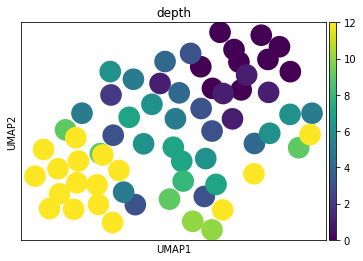

In [497]:
sc.pl.umap(adata_top, color='depth')

In [498]:
from ott.geometry.geometry import Geometry

def compute_tree_distances(tree):
    """
    Computes the matrix of pairwise distances between leaves of the tree
    """
    leaves = sim_inf.get_leaves(tree, include_root=False)
    num_leaves = len(leaves)
    distances = np.zeros([num_leaves, num_leaves])
    for i, leaf in enumerate(leaves):
        distance_dictionary, tmp = nx.multi_source_dijkstra(tree.to_undirected(), [leaf], weight = 'time')
        for j, target_leaf in enumerate(leaves):
            distances[i, j] = distance_dictionary[target_leaf]
    return distances

def create_geometry(cost_matrix: np.ndarray, scale='max') -> Geometry:
    cost_matrix = jnp.array(cost_matrix)
    if scale is None:
        pass
    elif scale == 'max':
        cost_matrix /= cost_matrix.max()
        assert cost_matrix.max() == 1.0
    elif scale == 'mean':
        cost_matrix /= np.mean(cost_matrix)
    elif scale == 'median':
        cost_matrix /= np.median(cost_matrix)
    else:
        raise NotImplementedError(scale)
        
    assert (cost_matrix >= 0).all()
    return Geometry(cost_matrix=cost_matrix)

In [735]:
if False:
    edist = compute_tree_distances(top)
    bdist = compute_tree_distances(bottom)
else:
    edist = sim_inf.barcode_distances(adata_top.obsm['barcodes'])
    ldist = sim_inf.barcode_distances(adata_bottom.obsm['barcodes'])

In [736]:
egeom = create_geometry(edist)
bgeom = create_geometry(bdist)
# using PCA from adata_{top,bottom} really screws up the results
joint = create_geometry(ot.utils.dist(jdata[jdata.obs['time_point'] == 0].obsm[state_key],
                                      jdata[jdata.obs['time_point'] == 1].obsm[state_key]))

In [737]:
distance_dictionary, path = nx.multi_source_dijkstra(G.to_undirected(), top_leaves)
children = defaultdict(list)
for n in bottom_leaves:
    top_leaf = path[n][0]
    assert top_leaf in top_leaves, top_leaf
    children[top_leaf].append(n)
    
true_coupling = np.zeros((len(top_leaves), len(bottom_leaves)), dtype=float)
true_coupling.shape
a = jnp.asarray(true_coupling.sum(1))
b = jnp.asarray(true_coupling.sum(0))

It.  |Loss        |Rel. loss   |Abs. loss   |tau         |converged   |eps         
-----------------------------------------------------------------------------------
    1|6.795360e-01|1.000000e+00|6.795360e-01|1.000000e+00|           1|1.000000e-03
    2|6.719339e-01|1.131386e-02|7.602165e-03|1.000000e+00|           1|1.000000e-03
    3|6.675580e-01|6.555056e-03|4.375880e-03|1.000000e+00|           1|1.000000e-03
    4|6.649615e-01|3.904724e-03|2.596491e-03|1.000000e+00|           1|1.000000e-03
    5|6.640220e-01|1.414908e-03|9.395297e-04|1.000000e+00|           1|1.000000e-03
    6|6.635395e-01|7.271082e-04|4.824650e-04|1.000000e+00|           1|1.000000e-03
    7|6.632580e-01|4.244024e-04|2.814883e-04|1.000000e+00|           1|1.000000e-03
    8|6.631137e-01|2.175575e-04|1.442654e-04|1.000000e+00|           1|1.000000e-03
    9|6.630463e-01|1.017754e-04|6.748177e-05|1.000000e+00|           1|1.000000e-03
   10|6.630008e-01|6.852486e-05|4.543204e-05|1.000000e+00|           1|1.000

   97|6.624722e-01|1.004540e-06|6.654801e-07|1.000000e+00|           1|1.000000e-03
   98|6.624715e-01|1.067953e-06|7.074883e-07|1.000000e+00|           1|1.000000e-03
   99|6.624707e-01|1.214709e-06|8.047092e-07|1.000000e+00|           1|1.000000e-03
  100|6.624699e-01|1.223061e-06|8.102412e-07|1.000000e+00|           1|1.000000e-03


<AxesSubplot:>

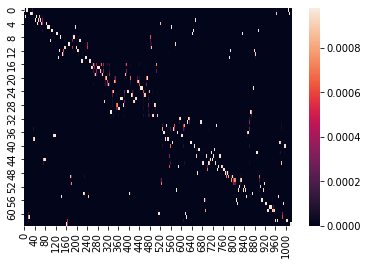

In [901]:
fgw = FusedGW(epsilon=1e-3, alpha=0.95)
# using marginals helps a lot
fgw.fit(egeom, bgeom, joint, max_iterations=100,
        linesearch=False,
        verbose=True, rtol=1e-9, atol=1e-9, scale_fn=jnp.max)
tmat = np.asarray(fgw.matrix)
sns.heatmap(tmat)

In [718]:
if True:
    tmp_adata = jdata[jdata.obs['time_point'] == 0]
    # TODO(michalk8): pass true tree to LOT
    ancestor_info = np.zeros((len(bottom_leaves), adata_bottom.obsm[state_key].shape[1]), dtype=float)

    seen = set()
    for i, (top_leaf, cs) in enumerate(children.items()):
        assert len(cs) in (16,), len(cs)
        true_coupling[i, cs] = 1.0 / len(cs)

        for c in cs:
            np.testing.assert_array_equal(ancestor_info[c], 0)
            data = np.asarray(tmp_adata[(tmp_adata.obs['cellID'] == top_leaf + 1)].obsm[state_key]).squeeze()
            ancestor_info[c] = data + np.random.normal(size=data.shape, scale=0.01)
            assert c not in seen
            seen.add(c)
            
assert seen == set(range(adata_bottom.n_obs))

In [898]:
G2 = gt_tree(adata, tree, create_cell=False)

for n in G2.nodes:
    try:
        G2.nodes[n]['time'] = G2.nodes[n]['node_depth']
    except:
        assert n == 'root'
        G2.nodes[n]['time'] = 0
        
max_depth = max(G2.nodes[n].get('node_depth', -1) for n in G2.nodes)

<AxesSubplot:>

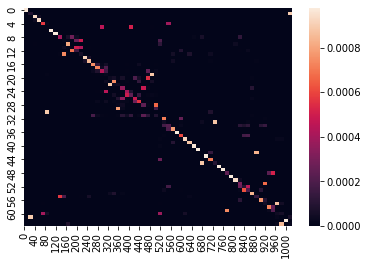

In [900]:
tmat2, _ = fit_lineage_coupling(jdata, 0, 1, G2, state_key='X_pca_30', time_key='time_point', epsilon=1e-2,
                                d1=6, d2=max_depth)
sns.heatmap(tmat2)

<AxesSubplot:>

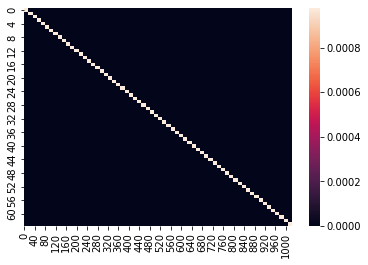

In [891]:
lot_cost = ot.utils.dist(
    tmp_adata.obsm[state_key],
    ancestor_info,
)
lot_cost /= np.median(lot_cost)
cmat = ot.sinkhorn([], [], lot_cost, 1e-3)
sns.heatmap(cmat)